# start a single-node ES cluster (local development)

```shell
$ docker run --rm -p 9200:9200 -p 9300:9300 -e "xpack.security.enabled=false" -e "discovery.type=single-node" docker.elastic.co/elasticsearch/elasticsearch:8.3.3
```

##  connect to created ES cluster.



In [1]:
from elasticsearch import Elasticsearch

es = Elasticsearch("http://localhost:9200")
es.info().body

{'name': '8f8df3a3fa9a',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': 'nwrVuUDxTf6CqSWI6tONjA',
 'version': {'number': '8.3.3',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': '801fed82df74dbe537f89b71b098ccaff88d2c56',
  'build_date': '2022-07-23T19:30:09.227964828Z',
  'build_snapshot': False,
  'lucene_version': '9.2.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

##  Read the dataset



https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots

Read the dataset and extract a sample from it, if we don't take a sample, the next steps may take a long time to run

In [2]:
import pandas as pd

df = (
    pd.read_csv("archive(1)/wiki_movie_plots_deduped.csv")
    .dropna()
    .sample(5000, random_state=42)
    .reset_index(drop=True)
)

 
 (py3.7) user@user-ThinkPad-X280:~/search$  curl -X GET "localhost:9200/_cluster/health?pretty"
 
{
  "cluster_name" : "docker-cluster",
  "status" : "red",
  "timed_out" : false,
  "number_of_nodes" : 1,
  "number_of_data_nodes" : 1,
  "active_primary_shards" : 0,
  "active_shards" : 0,
  "relocating_shards" : 0,
  "initializing_shards" : 0,
  "unassigned_shards" : 4,
  "delayed_unassigned_shards" : 0,
  "number_of_pending_tasks" : 0,
  "number_of_in_flight_fetch" : 0,
  "task_max_waiting_in_queue_millis" : 0,
  "active_shards_percent_as_number" : 0.0
}

The cluster health status is now RED,  
 
 (py3.7) user@user-ThinkPad-X280:~/search$ curl -X GET "localhost:9200/_cat/shards?v"

index    shard prirep state      docs store ip node

my_index 0     p      UNASSIGNED     

my_index 0     r      UNASSIGNED  

movies   0     p      UNASSIGNED   

movies   0     r      UNASSIGNED   


- The allocation explanation indicates that the shard for my_index is unassigned because the node has exceeded the disk usage high watermark. Specifically, the node is using more than 90% of its disk space, which prevents Elasticsearch from allocating the shard.

- Adjust Disk Watermark Settings:
temporarily adjust the disk watermark settings to allow shard allocation. 
Be cautious with this approach, as it may lead to performance degradation if the node runs out of disk space.



#(py3.7) user@user-ThinkPad-X280:~/search$ curl -X PUT "localhost:9200/_cluster/settings" -H 'Content-Type: application/json' -d'
> {
>   "transient": {
>     "cluster.routing.allocation.disk.watermark.low": "95%",
>     "cluster.routing.allocation.disk.watermark.high": "97%",
>     "cluster.routing.allocation.disk.watermark.flood_stage": "98%"
>   }
> }
> '
{"acknowledged":true,"persistent":{},"transient":{"cluster":{"routing":{"allocation":{"disk":{"watermark":{"low":"95%","flood_stage":"98%","high":"97%"}}}}}}}




 (py3.7) user@user-ThinkPad-X280:~/search$ curl -X GET "localhost:9200/_cluster/health?pretty"

{
  "cluster_name" : "docker-cluster",
  "status" : "yellow",
  "timed_out" : false,
  "number_of_nodes" : 1,
  "number_of_data_nodes" : 1,
  "active_primary_shards" : 1,
  "active_shards" : 1,
  "relocating_shards" : 0,
  "initializing_shards" : 0,
  "unassigned_shards" : 1,
  "delayed_unassigned_shards" : 0,
  "number_of_pending_tasks" : 0,
  "number_of_in_flight_fetch" : 0,
  "task_max_waiting_in_queue_millis" : 0,
  "active_shards_percent_as_number" : 50.0
}

(py3.7) user@user-ThinkPad-X280:~/search$ 

The cluster health status is now yellow, indicating that the primary shard is active and assigned, but the replica shard remains unassigned. This is a common state in a single-node cluster where replicas cannot be allocated because there's only one node.

Since Elasticsearch requires at least two nodes to allocate replicas, we should disable Replica Allocation. If we are running a single-node cluster and we don't need replicas. 

set the number of replicas to 0

(py3.7) user@user-ThinkPad-X280:~/search$

curl -X PUT "localhost:9200/my_index/_settings" -H 'Content-Type: application/json' -d '{
>   "index": {
>     "number_of_replicas": 0
>   }
> }'

(py3.7) user@user-ThinkPad-X280:~/search$ curl -X GET "localhost:9200/_cluster/health?pretty"

{
  "cluster_name" : "docker-cluster",
  "status" : "green",
  "timed_out" : false,
  "number_of_nodes" : 1,
  "number_of_data_nodes" : 1,
  "active_primary_shards" : 1,
  "active_shards" : 1,
  "relocating_shards" : 0,
  "initializing_shards" : 0,
  "unassigned_shards" : 0,
  "delayed_unassigned_shards" : 0,
  "number_of_pending_tasks" : 0,
  "number_of_in_flight_fetch" : 0,
  "task_max_waiting_in_queue_millis" : 0,
  "active_shards_percent_as_number" : 100.0
}

The cluster health status is now GREEN!!! :) 

##  Create an index

An index is a collection of documents that ES stores and represents through a very efficient data structure called an inverted index.

This process is what allows ES to perform very fast full-text searches.



In [3]:
mappings = {
        "properties": {
            "title": {"type": "text", "analyzer": "english"},
            "ethnicity": {"type": "text", "analyzer": "standard"},
            "director": {"type": "text", "analyzer": "standard"},
            "cast": {"type": "text", "analyzer": "standard"},
            "genre": {"type": "text", "analyzer": "standard"},
            "plot": {"type": "text", "analyzer": "english"},
            "year": {"type": "integer"},
            "wiki_page": {"type": "keyword"}
    }
}

# Set timeout to 30 seconds
#es.indices.create(index="movies", mappings=mappings)
if not es.indices.exists(index="movies"):
    es.indices.create(index="movies", mappings=mappings)
else:
    print("Index 'movies' already exists. Choose a different name or delete it first.")
    es.indices.delete(index="movies")
    print("Remove Index 'movies'")
    es.indices.create(index="movies", mappings=mappings, timeout="30s")

##  Add data to the index

we can use `.index()` or `.bulk()` to add data to an index.

`.index()` adds one item at a time, while `.bulk()` add multiple items at the same time.



### Using `.index()`

In [4]:
for i, row in df.iterrows():
    doc = {
        "title": row["Title"],
        "ethnicity": row["Origin/Ethnicity"],
        "director": row["Director"],
        "cast": row["Cast"],
        "genre": row["Genre"],
        "plot": row["Plot"],
        "year": row["Release Year"],
        "wiki_page": row["Wiki Page"]
    }
            
    es.index(index="movies", id=i, document=doc)

### Using `.bulk()`

In [5]:
from elasticsearch.helpers import bulk

bulk_data = []
for i,row in df.iterrows():
    bulk_data.append(
        {
            "_index": "movies",
            "_id": i,
            "_source": {        
                "title": row["Title"],
                "ethnicity": row["Origin/Ethnicity"],
                "director": row["Director"],
                "cast": row["Cast"],
                "genre": row["Genre"],
                "plot": row["Plot"],
                "year": row["Release Year"],
                "wiki_page": row["Wiki Page"],
            }
        }
    )
bulk(es, bulk_data)

(5000, [])

### Check the number of documents indexed

In [6]:
es.indices.refresh(index="movies")
es.cat.count(index="movies", format="json")

ListApiResponse([{'epoch': '1718209770', 'timestamp': '16:29:30', 'count': '5000'}])

## 6️⃣ Make searches in the ES index

 running searches using index.

ES has a powerful DSL that to build many types of queries.

An example of a search that looks for movies starring Jack Nicholson, but whose director isn't Roman Polanski:

In [7]:
resp = es.search(
    index="movies",
    query={
        "bool": {
            "must": {
                "match": {
                    "cast": "jack nicholson",
                }
            },
            "filter": {"bool": {"must_not": {"match_phrase": {"director": "roman polanksi"}}}},
        },
    },
)
resp

ObjectApiResponse({'took': 7, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 84, 'relation': 'eq'}, 'max_score': 10.952391, 'hits': [{'_index': 'movies', '_id': '461', '_score': 10.952391, '_source': {'title': 'The King of Marvin Gardens', 'ethnicity': 'American', 'director': 'Bob Rafelson', 'cast': 'Jack Nicholson, Ellen Burstyn, Bruce Dern', 'genre': 'drama', 'plot': "David and Jason are estranged brothers, the former a depressive living with his grandfather in Philadelphia where he runs a late-night radio talk show and the latter an extrovert con man working for gang boss Lewis in Atlantic City, where he lives with the manic-depressive Sally, former beauty queen and prostitute, and her stepdaughter Jessica. Begging David to come to Atlantic City and bail him out of jail, Jason once freed persuades him to stay on in his hotel suite with the two women.\r\nTensions grow between the four as Jason pursues a ludicrous d

In [8]:
resp

ObjectApiResponse({'took': 7, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 84, 'relation': 'eq'}, 'max_score': 10.952391, 'hits': [{'_index': 'movies', '_id': '461', '_score': 10.952391, '_source': {'title': 'The King of Marvin Gardens', 'ethnicity': 'American', 'director': 'Bob Rafelson', 'cast': 'Jack Nicholson, Ellen Burstyn, Bruce Dern', 'genre': 'drama', 'plot': "David and Jason are estranged brothers, the former a depressive living with his grandfather in Philadelphia where he runs a late-night radio talk show and the latter an extrovert con man working for gang boss Lewis in Atlantic City, where he lives with the manic-depressive Sally, former beauty queen and prostitute, and her stepdaughter Jessica. Begging David to come to Atlantic City and bail him out of jail, Jason once freed persuades him to stay on in his hotel suite with the two women.\r\nTensions grow between the four as Jason pursues a ludicrous d

##  Delete documents from the index

This will delete the document 9140 from the index:

In [9]:
es.delete(index = "movies", id = "2500")

ObjectApiResponse({'_index': 'movies', '_id': '2500', '_version': 3, 'result': 'deleted', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 10000, '_primary_term': 1})

 ## Delete an index

In [10]:
es.options(ignore_status=[400,404]).indices.delete(index='movies')

ObjectApiResponse({'acknowledged': True})

 # Second example for Indexing and searching 

In [11]:
from elasticsearch import Elasticsearch
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def index_document():
    es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])
    
    # Sample document
    doc = {
        'title': 'Elasticsearch in Action',
        'author': 'John Doe',
        'published_date': '2023-01-01'
    }
    
    # Index the document
    response = es.index(index="my_index", id=1, document=doc)
    logger.info(f"Indexing document response: {response}")

if __name__ == "__main__":
    index_document()


INFO:elastic_transport.transport:PUT http://localhost:9200/my_index/_doc/1 [status:200 duration:0.010s]
INFO:__main__:Indexing document response: {'_index': 'my_index', '_id': '1', '_version': 2, 'result': 'updated', '_shards': {'total': 1, 'successful': 1, 'failed': 0}, '_seq_no': 2, '_primary_term': 1}


-- successfully indexed a document

-- Indexed a sample document with ID 1 into my_index

-- Elasticsearch cluster is working correctly


(py3.7) user@user-ThinkPad-X280:~/search$ curl -X GET "localhost:9200/my_index/_doc/1?pretty"

{
  "_index" : "my_index",
  "_id" : "1",
  "_version" : 1,
  "_seq_no" : 1,
  "_primary_term" : 1,
  "found" : true,
  "_source" : {
    "title" : "Elasticsearch in Action",
    "author" : "John Doe",
    "published_date" : "2023-01-01"
  }
}





In [12]:
from elasticsearch import Elasticsearch
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def search_documents():
    es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])
    
    # Search query
    query = {
        'query': {
            'match': {
                'title': 'Elasticsearch'
            }
        }
    }
    
    # Perform the search
    response = es.search(index="my_index", body=query)
    logger.info(f"Search response: {response}")

if __name__ == "__main__":
    search_documents()


INFO:elastic_transport.transport:POST http://localhost:9200/my_index/_search [status:200 duration:0.006s]
INFO:__main__:Search response: {'took': 2, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 0.6407243, 'hits': [{'_index': 'my_index', '_id': '1', '_score': 0.6407243, '_source': {'title': 'Elasticsearch in Action', 'author': 'John Doe', 'published_date': '2023-01-01'}}]}}


- Executed a search query for documents with the title "Elasticsearch".
- Received a response indicating the document was found:


(py3.7) user@user-ThinkPad-X280:~/search$ curl -X GET "localhost:9200/my_index/_search?q=title:Elasticsearch&pretty"

{
  "took" : 29,
  "timed_out" : false,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  },
  "hits" : {
    "total" : {
      "value" : 1,
      "relation" : "eq"
    },
    "max_score" : 0.6407243,
    "hits" : [
      {
        "_index" : "my_index",
        "_id" : "1",
        "_score" : 0.6407243,
        "_source" : {
          "title" : "Elasticsearch in Action",
          "author" : "John Doe",
          "published_date" : "2023-01-01"
        }
      }
    ]
  }
}


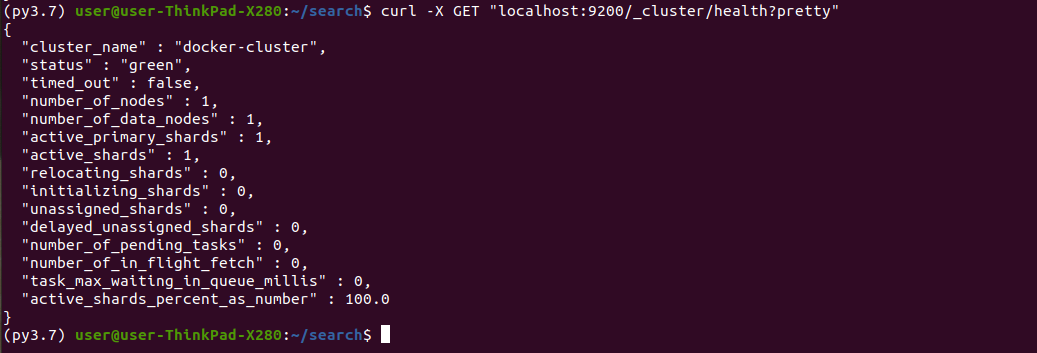

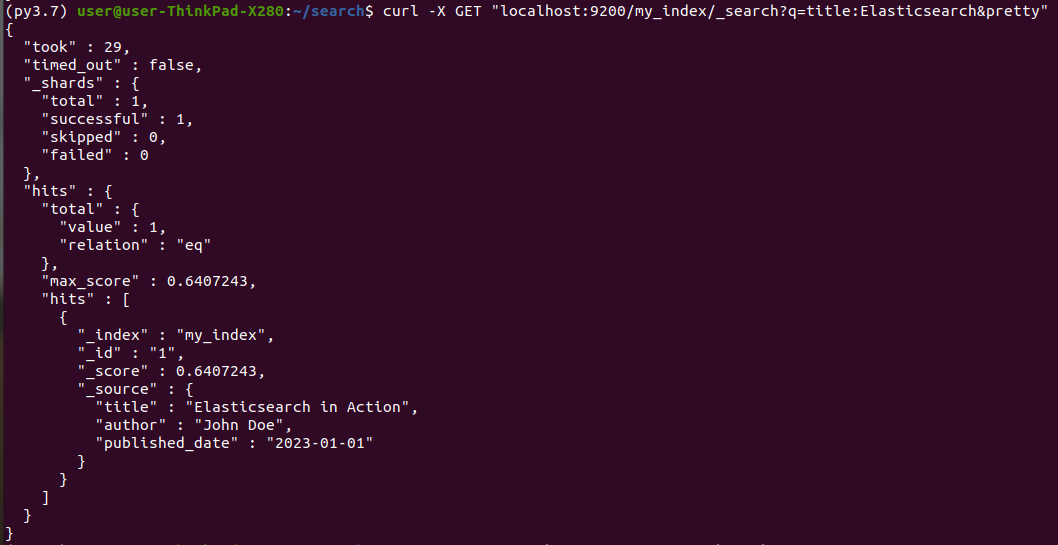

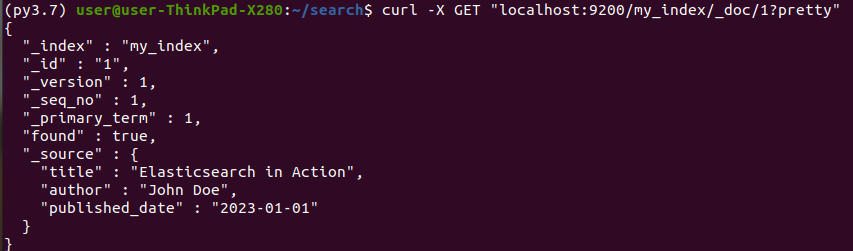